<a href="https://colab.research.google.com/github/saghar-trade/Time-series/blob/main/Mlairline_nodiffrencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score


In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [4]:


path = "/content/drive/MyDrive/air_passengers.csv"
df = pd.read_csv(path, index_col='Month', parse_dates=True)
print(df.head())


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [5]:
df['LogPassengers'] = np.log(df['Passengers'])


In [6]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]


In [7]:
print(train.tail())
print(test.head())

            Passengers  LogPassengers
Month                                
1959-08-01         559       6.326149
1959-09-01         463       6.137727
1959-10-01         407       6.008813
1959-11-01         362       5.891644
1959-12-01         405       6.003887
            Passengers  LogPassengers
Month                                
1960-01-01         417       6.033086
1960-02-01         391       5.968708
1960-03-01         419       6.037871
1960-04-01         461       6.133398
1960-05-01         472       6.156979


In [8]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogPassengers'].to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)


In [9]:
X = np.array(X)
Y = np.array(Y)

# تقسیم داده‌ها به train/test
Xtrain, Xtest = X[:-Ntest], X[-Ntest:]
Ytrain, Ytest = Y[:-Ntest], Y[-Ntest:]

print(Xtrain.shape, Xtest.shape)

(122, 10) (12, 10)


In [10]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
Ypred = lr.predict(Xtest)
mape = mean_absolute_percentage_error(Ytest, Ypred)
r2 = r2_score(Ytest, Ypred)

0.6910953044565584

 Boolean Index

In [14]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False  # first T values are not predictable


In [15]:
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)


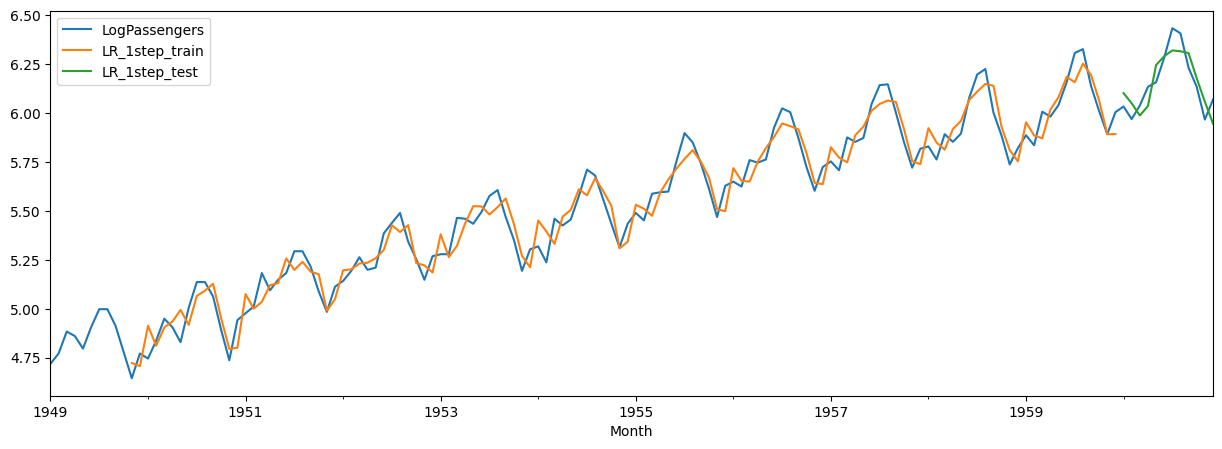

In [16]:
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));


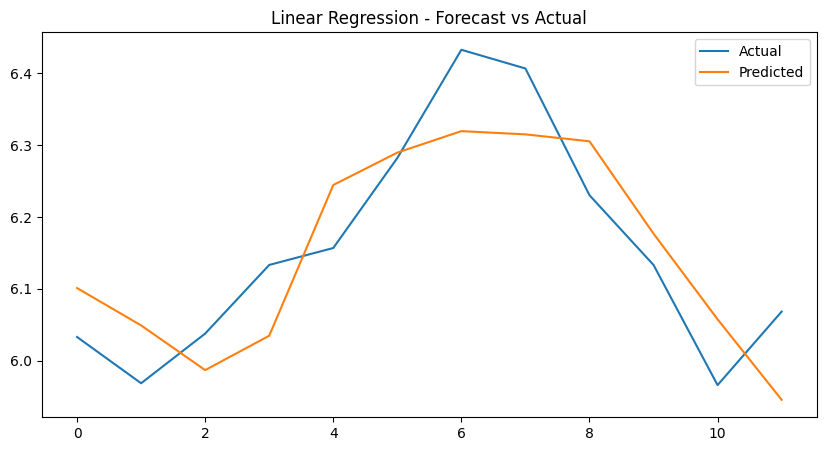

In [12]:
plt.figure(figsize=(10,5))
plt.plot(Ytest, label='Actual')
plt.plot(Ypred, label='Predicted')
plt.title('Linear Regression - Forecast vs Actual')
plt.legend()
plt.show()

# **Multi Step Forecast**

In [19]:
multistep_predictions = []

last_x = Xtest[0]  # اولین ورودی تست (آخرین 10 ماه واقعی قبل از بخش تست)


In [20]:
while len(multistep_predictions) < len(Ytest):
    y_pred = lr.predict(last_x.reshape(1, -1))[0]  # پیش‌بینی مقدار بعدی
    multistep_predictions.append(y_pred)
    # به آرایه 10‌تایی اضافه کن و یکی از اول حذف کن
    last_x = np.roll(last_x, -1)
    last_x[-1] = y_pred


In [21]:
df.loc[test_idx, 'LR_multistep_test'] = multistep_predictions


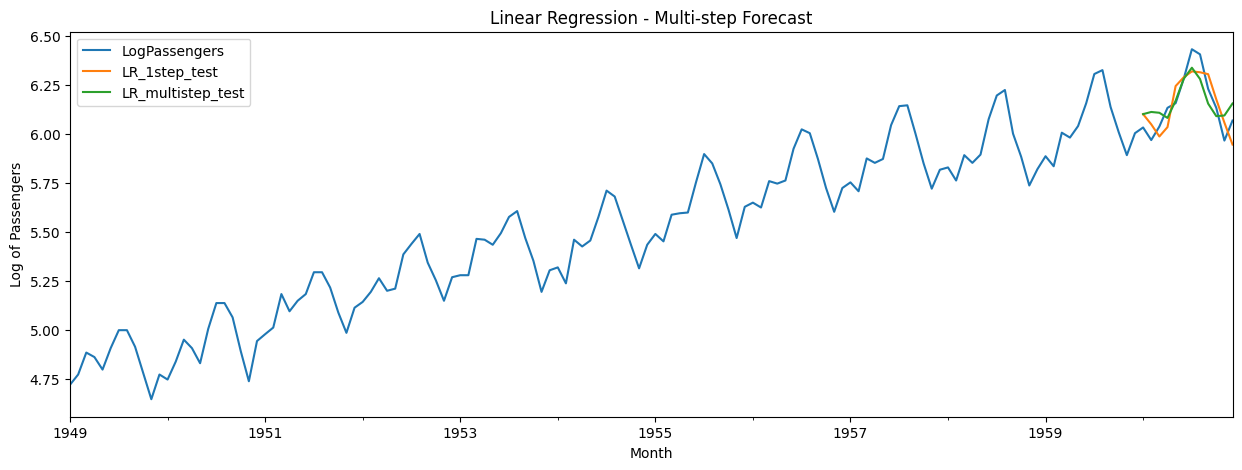

In [22]:
df[['LogPassengers', 'LR_1step_test', 'LR_multistep_test']].plot(figsize=(15,5))
plt.title("Linear Regression - Multi-step Forecast")
plt.ylabel("Log of Passengers")
plt.show()

In [23]:
# make multi-output supervised dataset
Tx = T          # تعداد ورودی‌ها (مثلاً 10 ماه گذشته)
Ty = Ntest      # تعداد خروجی‌ها (مثلاً 12 ماه آینده)
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]                # ورودی: 10 ماه گذشته
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]          # خروجی: 12 ماه بعد
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)


In [24]:
print('X.shape : ', X.shape)
print('Y.shape : ', Y.shape)

X.shape :  (123, 10)
Y.shape :  (123, 12)


In [25]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]


In [26]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)


0.9734607773512526

In [27]:
lr.score(Xtest_m, Ytest_m)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [28]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())


0.8018749676715242

In [35]:
multistep_predictions = []
last_x = Xtest[0].copy()

while len(multistep_predictions) < len(Ytest):
    y_pred = lr.predict(last_x.reshape(1, -1)).ravel()[0]   # ← صاف کن تا یه عدد بشه
    multistep_predictions.append(y_pred)
    last_x = np.roll(last_x, -1)
    last_x[-1] = y_pred

df.loc[test_idx, 'LR_multistep'] = multistep_predictions



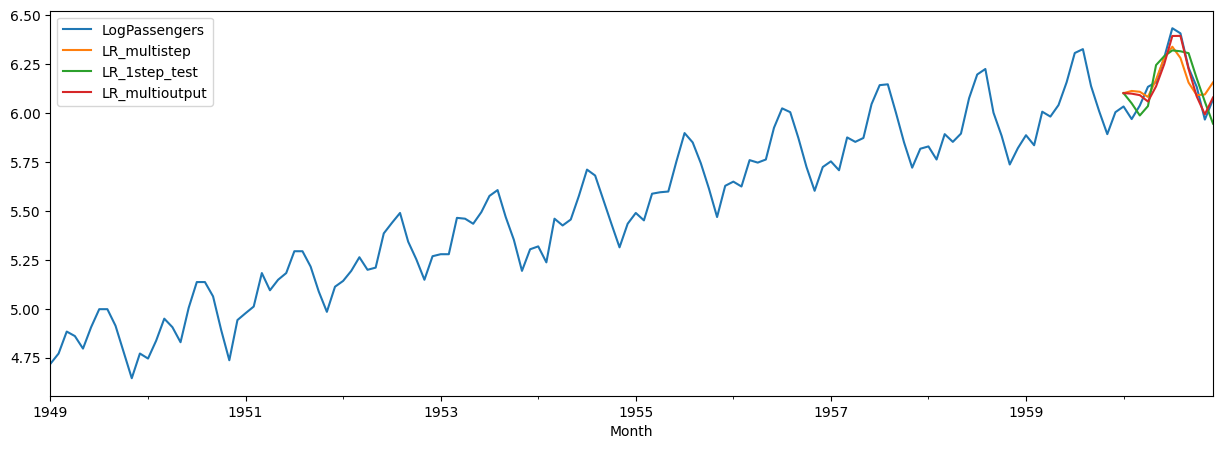

In [36]:
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));


In [37]:
# === محاسبه‌ی خطای MAPE برای دو مدل ===
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput']
)
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.012229325023475396
multi-output MAPE: 0.007178924475039778


### test other models

In [38]:
def one_step_and_multistep_forecast(model, name):
    # آموزش مدل
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)

    # ذخیره پیش‌بینی‌های یک‌مرحله‌ای (train و test)
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
    df.loc[test_idx,  f'{name}_1step_test']  = model.predict(Xtest)

    # ساخت پیش‌بینی چندمرحله‌ای
    multistep_predictions = []
    last_x = Xtest[0].copy()

    while len(multistep_predictions) < len(Ytest):
        y_pred = model.predict(last_x.reshape(1, -1)).ravel()[0]
        multistep_predictions.append(y_pred)
        last_x = np.roll(last_x, -1)
        last_x[-1] = y_pred

    # ذخیره‌ی پیش‌بینی چندمرحله‌ای
    df.loc[test_idx, f'{name}_multistep'] = multistep_predictions

    # محاسبه‌ی MAPE برای این مدل
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print(f"{name} multi-step MAPE:", mape)


In [39]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

one_step_and_multistep_forecast(LinearRegression(), "LR")
one_step_and_multistep_forecast(Ridge(), "Ridge")
one_step_and_multistep_forecast(Lasso(), "Lasso")


One-step forecast: LR
LR multi-step MAPE: 0.012229325023475304
One-step forecast: Ridge
Ridge multi-step MAPE: 0.01338686652292258
One-step forecast: Lasso
Lasso multi-step MAPE: 0.09964429367183902
